In [3]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


#### 1.1 Import Libraries

In [4]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline


from tensorflow.keras import utils
from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#from google.colab.patches import cv2_imshow
# For showing a ImageGrid 
from mpl_toolkits.axes_grid1 import ImageGrid

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


Set seed to retrieve same results for each execution

In [5]:
tf.random.set_seed(0)
np.random.seed(0)

#### 1.2 Load Images from npy file

In [6]:
data = np.load('/content/gdrive/My Drive/aiml_practice/image_classification/images.npy')
labels = pd.read_csv('/content/gdrive/My Drive/aiml_practice/image_classification/Labels.csv')

#### 1.3 Shape of image dataset

In [7]:
print(data.shape)
print(data[0].shape)

(4750, 128, 128, 3)
(128, 128, 3)


* Dataset has 4750 images
* Each image is of size 128 X 128 having 3 color channels R,G,B

Shape of labels

In [8]:
print(labels.shape)

(4750, 1)


In [9]:
labels.head()

Label
0  Small-flowered Cranesbill
1  Small-flowered Cranesbill
2  Small-flowered Cranesbill
3  Small-flowered Cranesbill
4  Small-flowered Cranesbill

#### 1.4 Visualise a sample of 4 images from the dataset in a Image Grid

In [10]:
original_images = data[:4]

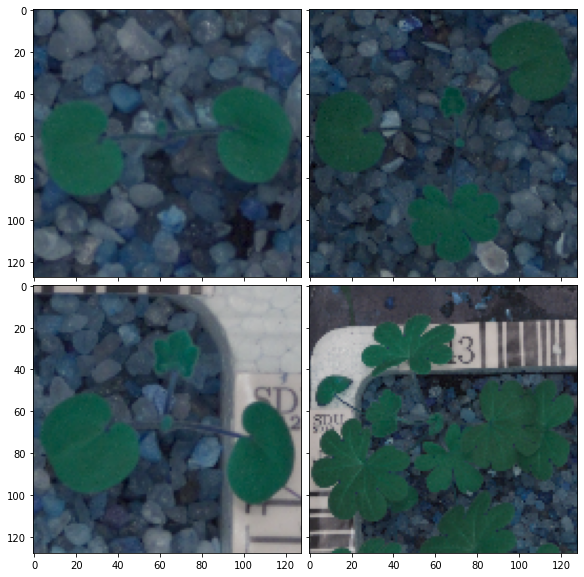

In [11]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, original_images):
    ax.imshow(im)

plt.show()

Apply Sobel filter to highlight edges

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


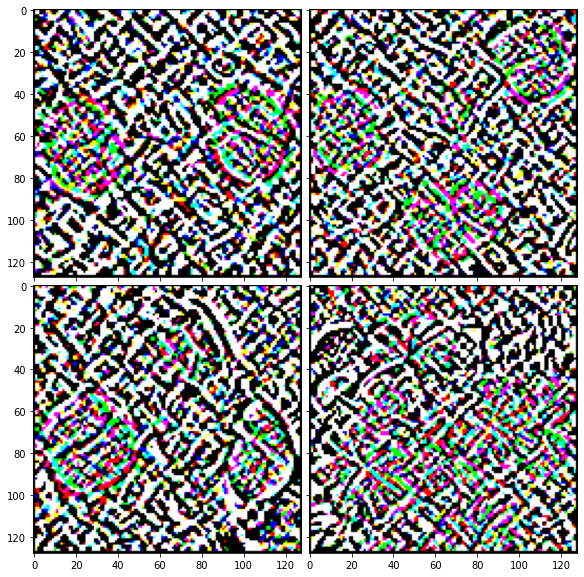

In [12]:
images_with_filters = [ cv2.Sobel(img,cv2.CV_64F,1,1,ksize=5) for img in original_images ]
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, images_with_filters):
    ax.imshow(im)

plt.show()

### 2 Data Pre-Processing

* Perform Normalization by dividing pixel values with 255 to bring the values in to the range of 0-1
* Apply Gaussian Blurring
* Visualize data showing 
  * Original Image
  * Filter on Original Image
  * Normalized and Blurred Image
  * Filter on Normalized and Blurred Image

#### 2.1 Normalization

In [13]:
#Data before Normalization
data[0]

array([[[ 35,  52,  78],
        [ 36,  49,  76],
        [ 31,  45,  69],
        ...,
        [ 78,  95, 114],
        [ 76,  93, 110],
        [ 80,  95, 109]],

       [[ 33,  46,  68],
        [ 37,  50,  73],
        [ 48,  65,  83],
        ...,
        [ 81,  96, 113],
        [ 74,  89, 105],
        [ 83,  95, 109]],

       [[ 34,  50,  68],
        [ 35,  52,  72],
        [ 70,  85, 101],
        ...,
        [ 83,  97, 112],
        [ 79,  94, 108],
        [ 79,  94, 107]],

       ...,

       [[ 35,  50,  69],
        [ 42,  57,  73],
        [ 42,  57,  72],
        ...,
        [ 60,  76,  92],
        [ 67,  81,  97],
        [ 64,  77,  95]],

       [[ 36,  52,  67],
        [ 48,  63,  78],
        [ 41,  57,  73],
        ...,
        [ 44,  66,  83],
        [ 58,  76,  91],
        [ 57,  74,  90]],

       [[ 44,  58,  70],
        [ 43,  57,  73],
        [ 40,  55,  72],
        ...,
        [ 41,  70,  92],
        [ 55,  78,  97],
        [ 61,  79,  96]]

Apply Normalization to get values between 0-1

In [14]:
data=data.astype('float32')
data/=255.0

#### 2.2 Apply Gaussian Blurring

Apply Gaussian Blur with a 5 X 5 filter

In [15]:
X = np.apply_along_axis(
    lambda img: cv2.GaussianBlur(img, (5, 5), 0), 
    1, 
    data.reshape((-1, 128, 128,3))
)
X = X.reshape((-1, 128, 128,3))

In [16]:
blurred_images = X[:4]

Display images after pre-processing

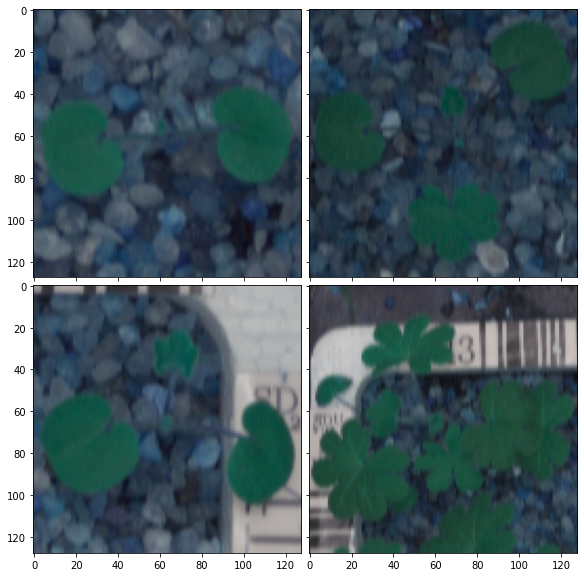

In [17]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, blurred_images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

Images now show soft edges

Apply Sobel filter on blurred images and display

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


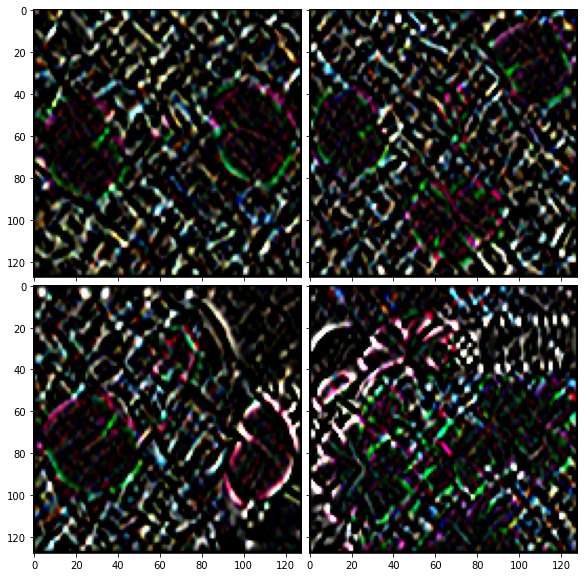

In [18]:
images_with_blurr_filter = [ cv2.Sobel(img,cv2.CV_64F,1,1,ksize=5) for img in blurred_images ]
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, images_with_blurr_filter):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

After applying Gaussian filter, edges are more visible when compared to that of the orignal images

Display comparision of all 4 versions of 2 images

Display a grid of 

* (0,0) Original Image
* (1,1) Sobel Filter on Original Image
* (1,0) Blurred Image
* (1,1) Soble Filter on Blurred Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


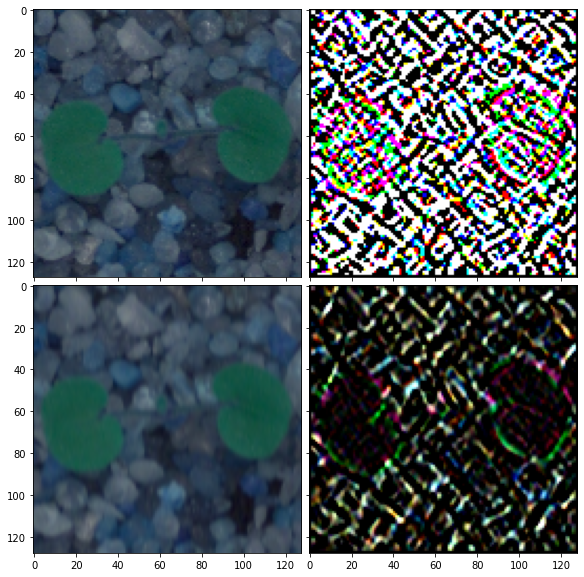

In [19]:
img_idx=0
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, [original_images[img_idx],images_with_filters[img_idx],blurred_images[img_idx],images_with_blurr_filter[img_idx]] ):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


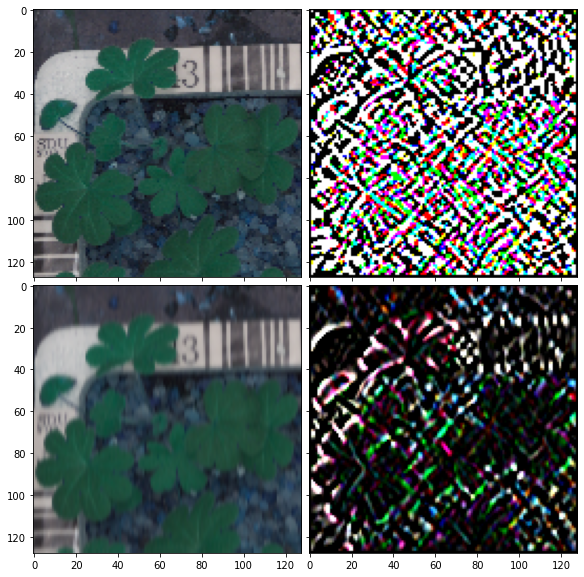

In [20]:
img_idx=3
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, [original_images[img_idx],images_with_filters[img_idx],blurred_images[img_idx],images_with_blurr_filter[img_idx]] ):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

For both the samples the edges are highlighted and more visible in the sobel filter image applied on the gaussian-blurred image 

### 3 Data Preparation

Examine Labels

In [21]:
labels["Label"].nunique()

12

In [22]:
labels["Label"].value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: Label, dtype: int64

There are 12 classes of images

#### 3.1 Convert Labels to one-hot vectors

In [23]:
enc = LabelBinarizer()
enc.fit(labels)
y = enc.fit_transform(labels)

In [24]:
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [25]:
y[2000]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

The encoded vector has 12 elements per vector with 1 representing one class

In [26]:
enc.classes_

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype='<U25')

Display class name for two vectors

In [27]:
print("y[0] from labels: ", labels.iloc[0,0])
print("y[2000] from labels: ", labels.iloc[2000,0])

y[0] from labels:  Small-flowered Cranesbill
y[2000] from labels:  Common Chickweed


Define a lookup function to get class label from a one-hot vector

In [28]:
def get_class_label(vector):
  return enc.classes_[vector.argmax()]

Define a function to display an image with title

In [29]:
def display_image_with_label(img,label):
  plt.figure(figsize=(6,6))
  plt.title(get_class_label(label))
  plt.imshow(img)
  plt.grid(None)

#### 3.2 Get Label for y[0]

In [30]:
get_class_label(y[0])

'Small-flowered Cranesbill'

In [31]:
get_class_label(y[2000])

'Common Chickweed'

#### 3.3 Split dataset into train, test and validation

* Split dataset into 70/30 Train/Test+Validation
* Further split Test+Validation in to 50/50 split

In [32]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.3,shuffle=True,stratify=y, random_state=0)

In [33]:
print("X_train",X_train.shape)
print("X_test_valid",X_test_valid.shape)
print("y_train",y_train.shape)
print("y_test_valid",y_test_valid.shape)

X_train (3325, 128, 128, 3)
X_test_valid (1425, 128, 128, 3)
y_train (3325, 12)
y_test_valid (1425, 12)


In [34]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.5,shuffle=True,stratify=y_test_valid, random_state=0)

In [35]:
print("X_train",X_train.shape)
print("X_test",X_test.shape)
print("X_valid",X_valid.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)
print("y_valid",y_valid.shape)

X_train (3325, 128, 128, 3)
X_test (712, 128, 128, 3)
X_valid (713, 128, 128, 3)
y_train (3325, 12)
y_test (712, 12)
y_valid (713, 12)


Get Label of y_train[0]

In [36]:
get_class_label(y_train[0])

'Common Chickweed'

Display one image from each set

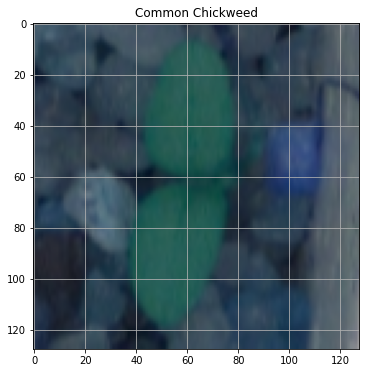

In [37]:
display_image_with_label(X_train[0],y_train[0])

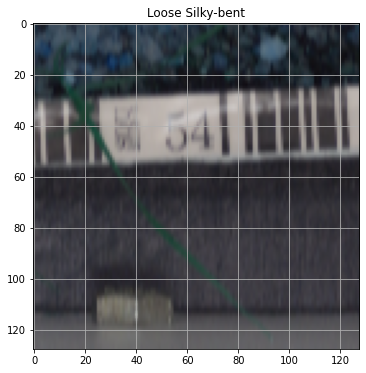

In [38]:
display_image_with_label(X_test[0],y_test[0])

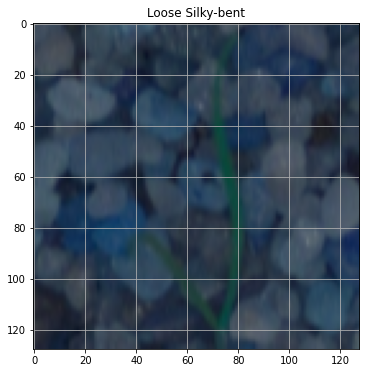

In [39]:
display_image_with_label(X_valid[0],y_valid[0])

The dataset shape of 128 X 128 X 3 can be provided as an input to the CNN without any reshape/flatten. The Conv2D input layer of CNN can take 2D form of images and apply Convolution filters of specified size, unlike ANNs which need a flattened 1D vector.

### 4 Build and Fit a CNN model

Create a model with 

* Convolution Layer of 32 featuremaps with 5X5 filter and relu
* Convolution Layer of 64 featuremaps with 5X5 filter and relu
* Convolution Layer of 64 featuremaps with 3X3 filter and relu
* Convolution Layer of 64 featuremaps with 3X3 filter and relu

* Add BatchNormalization, MaxPooling of 2X2 and Dropout layers after each Convolution Layer (increase from 0.2 to 0.5)

* Add a 256 node Dense layer with relu, followed by 50% dropout
* Add a 12 node (num_classes=12) softmax layer as the last layer to predict classes


In [40]:
batch_size = None


#Create a Convolution layer with relu activation layer providing input shape of 128 X 128 X 3
model = models.Sequential()
model.add(layers.Conv2D(32,(5,5),padding="same",activation="relu",input_shape=X_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64,(5,5),padding="same",activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64,(3,3),padding="same",activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

Display the topology of CNN using keras plot_model

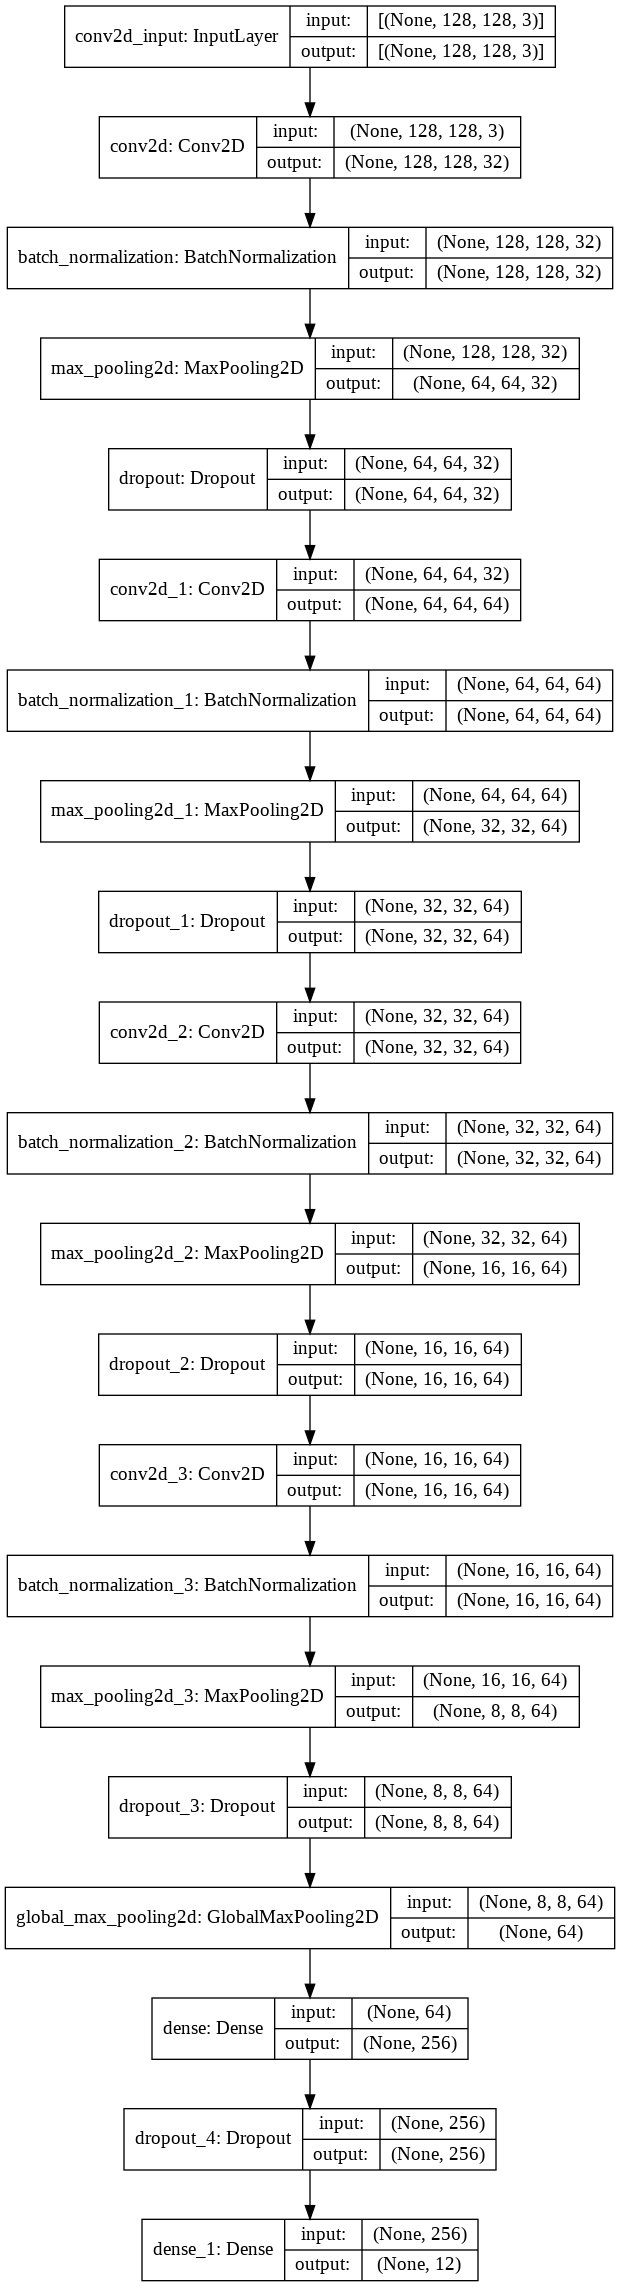

In [41]:
utils.plot_model(model, to_file="output_file.png", show_shapes=True)

Create an Adam optimizer

In [42]:
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

Compile model with a loss function of categorical crossentropy

In [43]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Define Earlystopping and Model checkpoint to stop model training after the model reaches a 

In [44]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

In [45]:
model_checkpoint =  ModelCheckpoint('cv_checkpint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

In [46]:
num_classes = 12
epochs = 40
num_predictions = 20

In [ ]:
history = model.fit(X_train,
                    y_train,
                    batch_size=None,
                    epochs=epochs,
                    validation_data=(X_valid, y_valid),
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stopping,model_checkpoint])

Epoch 1/40
104/104 [==============================] - 206s 2s/step - loss: 3.3918 - accuracy: 0.1711 - val_loss: 2.4963 - val_accuracy: 0.1403

Epoch 00001: val_loss improved from inf to 2.49631, saving model to cv_checkpint_01_loss2.4963.h5
Epoch 2/40
104/104 [==============================] - 203s 2s/step - loss: 1.9477 - accuracy: 0.3272 - val_loss: 2.7260 - val_accuracy: 0.1374

Epoch 00002: val_loss did not improve from 2.49631
Epoch 3/40
104/104 [==============================] - 203s 2s/step - loss: 1.7068 - accuracy: 0.4012 - val_loss: 3.2825 - val_accuracy: 0.1374

Epoch 00003: val_loss did not improve from 2.49631
Epoch 4/40
104/104 [==============================] - 209s 2s/step - loss: 1.5395 - accuracy: 0.4559 - val_loss: 3.0730 - val_accuracy: 0.1431

Epoch 00004: val_loss did not improve from 2.49631
Epoch 5/40
104/104 [==============================] - 204s 2s/step - loss: 1.4166 - accuracy: 0.5074 - val_loss: 2.2356 - val_accuracy: 0.2511

Epoch 00005: val_loss improve

In [ ]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()

NameError: ignored

**Observations**




In [ ]:
training_scores = model.evaluate(X_train,y_train)
print('Training loss :',scores[0])
print('Training accuracy :',scores[1])

### 5 Evaluate Model

#### 5.1 Model Scores

In [46]:
scores = model.evaluate(X_test,y_test,verbose=1)
print('Test loss :',scores[0])
print('Test accuracy :',scores[1])

23/23 [==============================] - 0s 18ms/step - loss: 0.6571 - accuracy: 0.7626
Test loss : 0.6570693254470825
Test accuracy : 0.7626404762268066


**Predict a single Image**

In [47]:
#enc.classes_[np.argmax(model.predict(X_test[0].reshape(1,128,128,3)))]
print("Predicted Label: ",get_class_label(model.predict(X_test[0].reshape(1,128,128,3))))
print("Actual Label: ",get_class_label(y_test[0]))

Predicted Label:  Loose Silky-bent
Actual Label:  Loose Silky-bent


**Predict Class Values for X_test**

In [48]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis=1)
y_pred_classes[:10]

array([ 6,  7,  8,  3,  2,  3,  3, 10, 10,  7])

**Convert y_test to y_test class values**

In [49]:
y_test_classes = np.argmax(y_test,axis=1)
y_test_classes[:10]

array([ 6,  7,  8,  3,  2,  3,  3, 10, 10,  7])

#### 5.2 Display Confusion Matrix

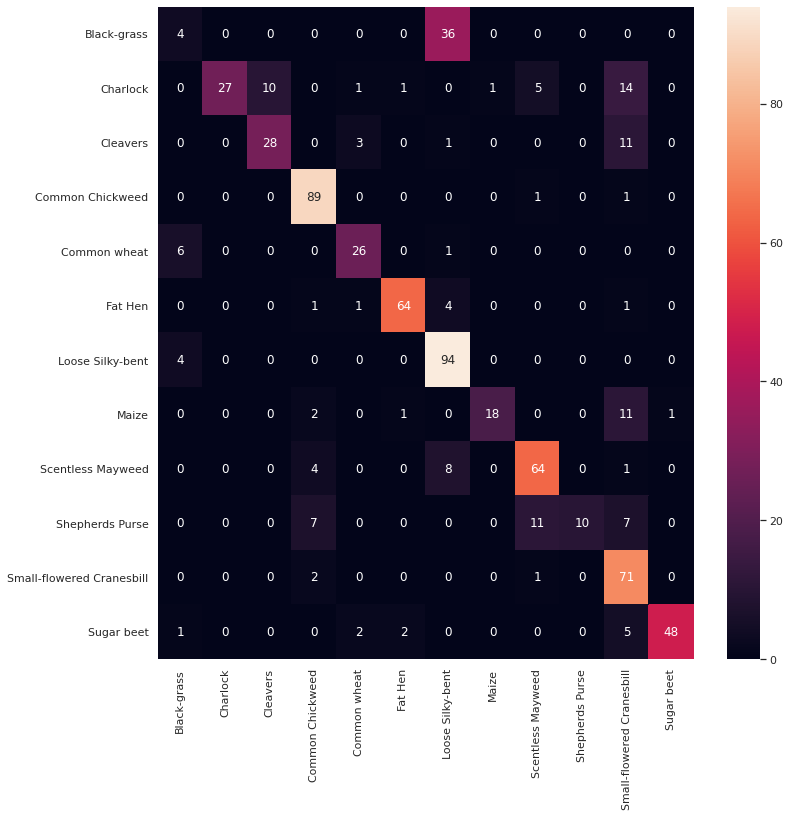

In [50]:
import seaborn as sns
cm = confusion_matrix(y_test_classes, y_pred_classes)
df_cm = pd.DataFrame(cm,index = [ x for x in enc.classes_],columns= [ x for x in enc.classes_])
sns.set(rc={'figure.figsize':(12,12)})
sns.heatmap(df_cm,annot=True,fmt='d');

**Observations**



In [51]:
report_dict = classification_report(y_test_classes, y_pred_classes, target_names=enc.classes_,output_dict=True)
pd.DataFrame(report_dict).T

precision    recall  f1-score    support
Black-grass                 0.266667  0.100000  0.145455   40.00000
Charlock                    1.000000  0.457627  0.627907   59.00000
Cleavers                    0.736842  0.651163  0.691358   43.00000
Common Chickweed            0.847619  0.978022  0.908163   91.00000
Common wheat                0.787879  0.787879  0.787879   33.00000
Fat Hen                     0.941176  0.901408  0.920863   71.00000
Loose Silky-bent            0.652778  0.959184  0.776860   98.00000
Maize                       0.947368  0.545455  0.692308   33.00000
Scentless Mayweed           0.780488  0.831169  0.805031   77.00000
Shepherds Purse             1.000000  0.285714  0.444444   35.00000
Small-flowered Cranesbill   0.581967  0.959459  0.724490   74.00000
Sugar beet                  0.979592  0.827586  0.897196   58.00000
accuracy                    0.762640  0.762640  0.762640    0.76264
macro avg                   0.793531  0.690389  0.701830  712.00000
weighted avg                0.788655  0.762640  0.742680  712.00000

### 6 Visualize Predictions

#### 6.1 x_test[2]

Actual Label:  Loose Silky-bent


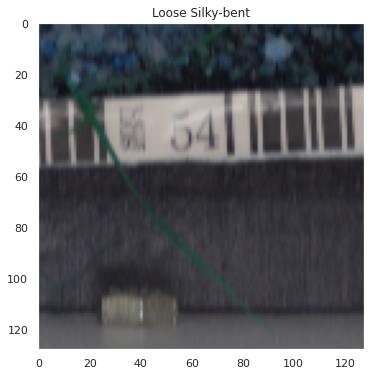

In [52]:
display_image_with_label(X_test[0],model.predict(X_test[0].reshape(1,128,128,3)))
print("Actual Label: ",get_class_label(y_test[0]))

#### 6.2 x_test[3]

Actual Label:  Common Chickweed


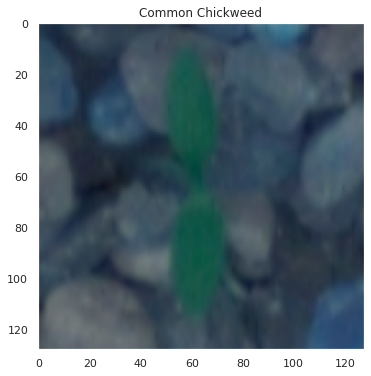

In [53]:
display_image_with_label(X_test[3],model.predict(X_test[3].reshape(1,128,128,3)))
print("Actual Label: ",get_class_label(y_test[3]))

#### 6.3 x_test[33]

Actual Label:  Scentless Mayweed


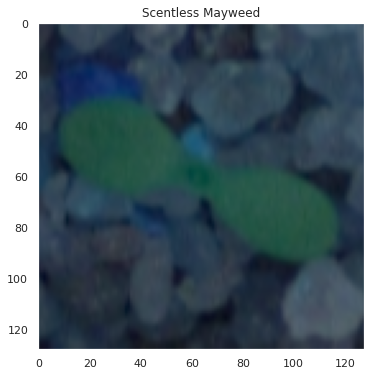

In [54]:
display_image_with_label(X_test[33],model.predict(X_test[33].reshape(1,128,128,3)))
print("Actual Label: ",get_class_label(y_test[33]))

#### 6.4 x_test[36]

Actual Label:  Charlock


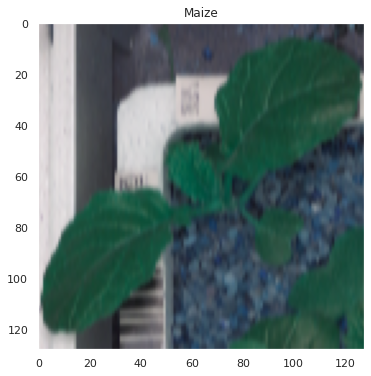

In [55]:
display_image_with_label(X_test[36],model.predict(X_test[36].reshape(1,128,128,3)))
print("Actual Label: ",get_class_label(y_test[36]))

#### 6.5 x_test[59]

Actual Label:  Sugar beet


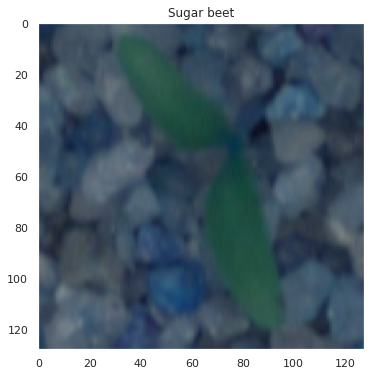

In [56]:
display_image_with_label(X_test[59],model.predict(X_test[59].reshape(1,128,128,3)))
print("Actual Label: ",get_class_label(y_test[59]))